In [1]:
import os
import glob
from collections import OrderedDict
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import yaml

from src.da_utils import data_loading, evaluation

In [6]:
MODEL_NAMES = ("CellDART", "CellDART_original")
FINAL_RESULTS_FOLDER = "results_FINAL"
CONFIGS_DIR = "configs"
DSETS = ("dlpfc", "pdac", "spotless" )
EARLY_STOPPING = False

PS_SEEDS = (3679, 343, 25, 234, 98098)
MODEL_SEEDS = (2353, 24385, 284, 86322, 98237)

def get_results_df(model_name, dset):
    if model_name == "CellDART_original_orig_hyper":
        model_name = "CellDART_original"
        CONFIG_FNAME = f"basic_config.yml"
    else:
        CONFIG_FNAME = f"{model_name.lower()}-final-{dset}-ht.yml"

    with open(os.path.join(CONFIGS_DIR, model_name, CONFIG_FNAME), "r") as f:
        config = yaml.safe_load(f)

    data_params = config["data_params"]
    model_params = config["model_params"]

    results_dfs = []
    for model_seed in MODEL_SEEDS:
        model_rel_path = data_loading.get_model_rel_path(
            model_name,
            model_params["model_version"],
            lib_seed_path=str(model_seed),
            **data_params,
        )
        results_folder = os.path.join(FINAL_RESULTS_FOLDER, "std", model_rel_path)

        if EARLY_STOPPING:
            results_fname = glob.glob(
                os.path.join(results_folder, "results_checkpt-*.csv"),
            )
            if len(results_fname) != 1:
                raise OSError(
                    f"{len(results_fname)} reverse_checkpt files found "
                    f"in {results_folder}; expected 1"
                )
            results_fname = os.path.basename(results_fname[0])
        else:
            results_fname = "results.csv"

        results_dfs.append(
            pd.read_csv(
                os.path.join(results_folder, results_fname),
                header=[0, 1],
                index_col=[0, 1, 2],
            )
        )
    
    results_df = pd.concat(results_dfs, keys=MODEL_SEEDS, names=["model_seed"])

    results_df.index.set_names("da", level=1, inplace=True)

    # if data_params.get("samp_split"):
    if results_df.index.get_level_values("SC Split").nunique() == 0:
        index_df = results_df.index.to_frame()
        index_df["SC Split"] = "test"
        results_df.index = pd.MultiIndex.from_frame(index_df)

    results_mean_samples_df = results_df.groupby(["model_seed", "da", "SC Split"]).mean()
    results_mean_samples_df.groupby(["da", "SC Split"]).mean()
    
    results_mean_samples_df = results_df.groupby(["model_seed", "da", "SC Split"]).mean()
    results_mean_samples_df.groupby(["da", "SC Split"]).mean()
    return results_mean_samples_df.groupby(["da", "SC Split"]).mean(), results_mean_samples_df.groupby(["da", "SC Split"]).std()
    # else:
    #     results_mean_samples_df = results_df.groupby(["model_seed", "da"]).mean()
    #     results_mean_samples_df.groupby(["da"]).mean()
        
    #     results_mean_samples_df = results_df.groupby(["model_seed", "da"]).mean()
    #     results_mean_samples_df.groupby(["da"]).mean()
    #     return results_mean_samples_df.groupby(["da"]).mean(), results_mean_samples_df.groupby(["da"]).std()       

In [7]:
# Pseudospots

results_df_d = OrderedDict()
results_dd_d = OrderedDict()
for dset in DSETS:
    results_d = OrderedDict((model_name, get_results_df(model_name, dset)) for model_name in MODEL_NAMES)
    results_dd_d[dset] = results_d
    for model_name in MODEL_NAMES:

        results_df, results_std_df = deepcopy(results_d[model_name])
        results_df.loc[:, :] = np.asarray(
            [
                f"{round(mean, 5)} ({round(std, 5)})"
                for mean, std in zip(results_df.values.flatten(), results_std_df.values.flatten())
            ]
        ).reshape(results_df.shape)
        results_d[model_name] = results_df

    real_key = "Pseudospots (Cosine Distance)"

    results_df_d[dset]= pd.concat({model_name:results_d[model_name].loc[("After DA (final model)", "test"), real_key] for model_name in MODEL_NAMES}, axis=1)

ps_cos_df = pd.concat(results_df_d)

In [8]:
ps_cos_df

CellDART  CellDART_original
dlpfc    train   0.28506 (0.0492)  0.24134 (0.01848)
         val    0.29726 (0.04793)  0.25193 (0.01802)
         test   0.29581 (0.04825)    0.24922 (0.018)
pdac     train  0.03806 (0.00338)  0.06136 (0.01308)
         val    0.03814 (0.00367)   0.0621 (0.01336)
         test   0.03794 (0.00311)  0.06093 (0.01248)
spotless train  0.07011 (0.01125)  0.07253 (0.01069)
         val    0.07159 (0.01139)  0.07413 (0.01105)
         test   0.07141 (0.01079)  0.07385 (0.01074)

In [9]:
all_dsets_milisi = OrderedDict()
for dset in DSETS:
    if dset=="spotless":
        milisi_key = "miLISI (perplexity=5)"
    else:
        milisi_key = "miLISI (perplexity=30)"
    one_data_set_milisi = OrderedDict()
    for model_name in MODEL_NAMES:
        scores = []
        splits = ["test", "val", "train"]
        for split in splits:
            samp_split = "test" if dset=="pdac" else split
            scores.append(results_dd_d[dset][model_name][milisi_key].loc[("After DA (final model)", samp_split), split])
        one_data_set_milisi[model_name] = pd.Series(scores, index=splits)
    all_dsets_milisi[dset] = pd.concat(one_data_set_milisi, axis=1)
milisi_df = pd.concat(all_dsets_milisi)

In [10]:
all_dsets_rf50 = OrderedDict()
for dset in DSETS:
    # if dset=="spotless":
    #     milisi_key = "miLISI (perplexity=5)"
    # else:
    #     milisi_key = "miLISI (perplexity=30)"
    one_data_set_rf50 = OrderedDict()
    for model_name in MODEL_NAMES:
        scores = []
        splits = ["test", "val", "train"]
        for split in splits:
            samp_split = "test" if dset=="pdac" else split
            scores.append(results_dd_d[dset][model_name]["RF50"].loc[("After DA (final model)", samp_split), split])
        one_data_set_rf50[model_name] = pd.Series(scores, index=splits)
    all_dsets_rf50[dset] = pd.concat(one_data_set_rf50, axis=1)
rf50_df = pd.concat(all_dsets_rf50)
rf50_df

CellDART  CellDART_original
dlpfc    test    0.9991 (0.00055)  0.99605 (0.00373)
         val    0.99899 (0.00054)  0.99465 (0.00445)
         train   0.99948 (0.0002)   0.9961 (0.00348)
pdac     test   0.99977 (0.00014)    0.99988 (9e-05)
         val      0.99994 (7e-05)  0.99984 (0.00028)
         train    0.99996 (2e-05)   0.9999 (0.00016)
spotless test     0.99998 (4e-05)    0.99996 (9e-05)
         val     0.9999 (0.00022)    0.99998 (4e-05)
         train  0.99978 (0.00029)  0.99986 (0.00012)

In [11]:
# AUCs and Cosine Distances

results_dd = OrderedDict()
for dset in DSETS:
    results_d = OrderedDict((model_name, get_results_df(model_name, dset)) for model_name in MODEL_NAMES)

    for model_name in MODEL_NAMES:
        results_df, results_std_df = results_d[model_name]
        results_df.loc[:, :] = np.asarray(
            [
                f"{round(mean, 6)} ({round(std, 6)})"
                for mean, std in zip(results_df.values.flatten(), results_std_df.values.flatten())
            ]
        ).reshape(results_df.shape)
        results_d[model_name] = results_df
    if dset == "spotless":
        real_key = "Real Spots (Cosine Distance)"
    elif dset == "pdac":
        real_key = "Real Spots (Mean AUC celltype)"
    elif dset == "dlpfc":
        real_key = "Real Spots (Mean AUC Ex1-10)"

    results_dd[dset]= pd.concat({model_name:results_d[model_name].loc[("After DA (final model)"), real_key].T for model_name in MODEL_NAMES})

AUC_cos_df = pd.concat(results_dd, axis=1)
AUC_cos_df

dlpfc                       \
SC Split                            test                train   
CellDART          0  0.670131 (0.027868)  0.632519 (0.033279)   
CellDART_original 0  0.630812 (0.009784)  0.591135 (0.036974)   

                                                         pdac  \
SC Split                             val                 test   
CellDART          0  0.659119 (0.033852)  0.517355 (0.007067)   
CellDART_original 0   0.610688 (0.02594)   0.519777 (0.00563)   

                                spotless                       \
SC Split                            test                train   
CellDART          0  0.147545 (0.076397)  0.674007 (0.044562)   
CellDART_original 0  0.208481 (0.133597)  0.733388 (0.048093)   

                                          
SC Split                             val  
CellDART          0  0.309453 (0.025501)  
CellDART_original 0   0.33517 (0.076165)

In [12]:
all_dsets_auc_cos = OrderedDict()
for dset in DSETS:
    if dset == "spotless":
        real_key = "Real Spots (Cosine Distance)"
    elif dset == "pdac":
        real_key = "Real Spots (Mean AUC celltype)"
    elif dset == "dlpfc":
        real_key = "Real Spots (Mean AUC Ex1-10)"
    one_data_set_auc_cos = OrderedDict()
    for model_name in MODEL_NAMES:
        scores = []
        splits = ["test", "val", "train"]
        for split in splits:
            if dset=="pdac" and split != "test":
                continue
            scores.append(results_dd_d[dset][model_name][real_key].loc[("After DA (final model)", split),"0"])
        one_data_set_auc_cos[model_name] = pd.Series(scores, index=splits[-len(scores):])
    all_dsets_auc_cos[dset] = pd.concat(one_data_set_auc_cos, axis=1)
auc_cos_df = pd.concat(all_dsets_auc_cos)
auc_cos_df

CellDART  CellDART_original
dlpfc    test   0.67013 (0.02787)  0.63081 (0.00978)
         val    0.65912 (0.03385)  0.61069 (0.02594)
         train  0.63252 (0.03328)  0.59114 (0.03697)
pdac     train  0.51736 (0.00707)  0.51978 (0.00563)
spotless test    0.14755 (0.0764)   0.20848 (0.1336)
         val     0.30945 (0.0255)  0.33517 (0.07616)
         train  0.67401 (0.04456)  0.73339 (0.04809)

In [13]:
results_dd_d[dset][model_name][real_key]

0
da                     SC Split                   
After DA (final model) test       0.20848 (0.1336)
                       train     0.73339 (0.04809)
                       val       0.33517 (0.07616)
Before DA              test      0.29613 (0.07634)
                       train     0.62659 (0.05608)
                       val       0.40642 (0.10539)

In [14]:
AUC_cos_df

dlpfc                       \
SC Split                            test                train   
CellDART          0  0.670131 (0.027868)  0.632519 (0.033279)   
CellDART_original 0  0.630812 (0.009784)  0.591135 (0.036974)   

                                                         pdac  \
SC Split                             val                 test   
CellDART          0  0.659119 (0.033852)  0.517355 (0.007067)   
CellDART_original 0   0.610688 (0.02594)   0.519777 (0.00563)   

                                spotless                       \
SC Split                            test                train   
CellDART          0  0.147545 (0.076397)  0.674007 (0.044562)   
CellDART_original 0  0.208481 (0.133597)  0.733388 (0.048093)   

                                          
SC Split                             val  
CellDART          0  0.309453 (0.025501)  
CellDART_original 0   0.33517 (0.076165)

In [15]:
pd.concat({model_name:results_d[model_name].loc[("After DA (final model)", "test"), "Pseudospots (Cosine Distance)"] for model_name in MODEL_NAMES}, axis=1).T

,train,val,test
CellDART,0.070108 (0.011253),0.071586 (0.011388),0.071406 (0.010785)
CellDART_original,0.072529 (0.010689),0.074129 (0.011051),0.073847 (0.010736)


In [16]:
pd.concat({model_name:results_d[model_name].loc[("After DA (final model)", "test"), "miLISI (perplexity=5)"] for model_name in MODEL_NAMES}, axis=1).T

,train,val,test
CellDART,1.044081 (0.034594),1.019236 (0.016618),1.024835 (0.023682)
CellDART_original,1.074578 (0.039456),1.071481 (0.055745),1.05944 (0.035255)


In [17]:
ps_cos_df.xs("test", level=1).T

,dlpfc,pdac,spotless
CellDART,0.29581 (0.04825),0.03794 (0.00311),0.07141 (0.01079)
CellDART_original,0.24922 (0.018),0.06093 (0.01248),0.07385 (0.01074)


In [23]:
all_df = pd.concat(
    [
        ps_cos_df.xs("test", level=1),
        rf50_df.xs("test", level=1),
        milisi_df.xs("test", level=1),
        auc_cos_df.loc[(auc_cos_df.index.get_level_values(1)=="test") | (auc_cos_df.index.get_level_values(0)=="pdac")].droplevel(1),
    ],
    keys = ["Pseudospots (Cosine Distance)", "RF50", "miLISI", "Real Spots"],
)

In [25]:
all_df.to_csv("tables/celldarts.csv")

In [20]:
auc_cos_df

CellDART  CellDART_original
dlpfc    test   0.67013 (0.02787)  0.63081 (0.00978)
         val    0.65912 (0.03385)  0.61069 (0.02594)
         train  0.63252 (0.03328)  0.59114 (0.03697)
pdac     train  0.51736 (0.00707)  0.51978 (0.00563)
spotless test    0.14755 (0.0764)   0.20848 (0.1336)
         val     0.30945 (0.0255)  0.33517 (0.07616)
         train  0.67401 (0.04456)  0.73339 (0.04809)

In [22]:
long_train_test = pd.read_csv("tables/early_stopping_LONG_TRAIN_TEST.csv")
long_train_val = pd.read_csv("tables/early_stopping_LONG_TRAIN_VAL.csv")
long_train_train = pd.read_csv("tables/early_stopping_LONG_TRAIN_TRAIN.csv")

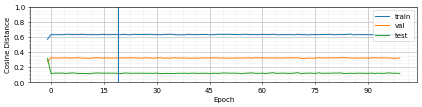

In [23]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(figsize=(10, 2), dpi=50)
# ax.plot(aucs_mean.index.to_series(), aucs_mean, marker="o")
ax.plot(long_train_train.iloc[:101,0], long_train_train.iloc[:101,1], label="train")
ax.plot(long_train_val.iloc[:101,0], long_train_val.iloc[:101,1], label="val")
ax.plot(long_train_test.iloc[:101,0], long_train_test.iloc[:101,1], label="test")
ax.axvline(19)
ax.set_ylim(0, 1)

# aucs_mean.to_csv("tables/early_stopping_LONG_TRAIN_VAL.csv")

# n_epochs = aucs_mean.index.max() + 1
# x_text = best_epoch + (2 if best_epoch < n_epochs * 0.75 else -2)
# ha_text = "left" if best_epoch < n_epochs * 0.75 else "right"

ax.grid(which="major")
ax.minorticks_on()
ax.grid(which="minor", alpha=0.2)
# ax.text(
#     x=x_text,
#     y=0.15,
#     s=f"Best {metric_name}:\n{aucs_mean.loc[best_epoch]:.4f} at epoch {best_epoch}",
#     ha=ha_text,
#     size="small",
# )
# ax.set_title(f"Average Cosine Distance (macro across types and samples)")

ax.set_xlabel("Epoch")
ax.set_ylabel("Cosine Distance")

ax.legend()

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.savefig(
    os.path.join("figures", "long_train.png"),
    bbox_inches="tight",
    dpi=300,
)

In [24]:
DA_MODELS = ["CellDART", "ADDA"]

In [42]:
da_perf_d = OrderedDict()
for dset in DSETS:
    if dset == "spotless":
        real_key = "Real Spots (Cosine Distance)"
    elif dset == "pdac":
        real_key = "Real Spots (Mean AUC celltype)"
    elif dset == "dlpfc":
        real_key = "Real Spots (Mean AUC Ex1-10)"
    scores = []
    for model_name in DA_MODELS:
        
        if dset=="pdac" and split != "test":
            split = "train"
        else:
            split = "test"
        scores.append(results_dd_d[dset][model_name][real_key].loc[(slice(None), split),"0"])
    da_perf_d[dset] = pd.concat(scores, keys=DA_MODELS, axis=1, names=["Dataset"])
da_df = pd.concat(da_perf_d, axis=1)
da_df = da_df.swaplevel(0, 1, axis=1).sort_index(axis=1).sort_index(ascending=False, axis=0)
da_df


Dataset                                       ADDA                     \
                                             dlpfc               pdac   
da                     SC Split                                         
Before DA              test      0.59167 (0.01418)  0.49461 (0.00163)   
After DA (final model) test      0.65349 (0.01498)  0.49236 (0.00141)   

Dataset                                                      CellDART  \
                                          spotless              dlpfc   
da                     SC Split                                         
Before DA              test      0.30749 (0.06652)  0.60007 (0.01197)   
After DA (final model) test      0.13697 (0.01517)  0.67013 (0.02787)   

Dataset                                                                
                                              pdac           spotless  
da                     SC Split                                        
Before DA              test      0.49037 (0.00364)  0.22675 (0.06909)  
After DA (final model) test      0.51736 (0.00707)   0.14755 (0.0764)

In [43]:
milisi_da_perf_d = OrderedDict()
for dset in DSETS:
    if dset == "spotless":
        real_key = "miLISI (perplexity=5)"
    else:
        real_key = "miLISI (perplexity=30)"
    scores = []
    for model_name in DA_MODELS:
        
        if dset=="pdac" and split != "test":
            split = "train"
        else:
            split = "test"
        scores.append(results_dd_d[dset][model_name][real_key].loc[(slice(None), split),"test"])
    milisi_da_perf_d[dset] = pd.concat(scores, keys=DA_MODELS, axis=1)
milisi_da_df = pd.concat(milisi_da_perf_d, axis=1, names=["Dataset"])
milisi_da_df = milisi_da_df.swaplevel(0, 1, axis=1).sort_index(axis=1).sort_index(ascending=False, axis=0)
milisi_da_df


ADDA                     \
Dataset                                      dlpfc               pdac   
da                     SC Split                                         
Before DA              test              1.0 (0.0)  1.00101 (0.00126)   
After DA (final model) test      1.25775 (0.03382)  1.81931 (0.01604)   

                                                     CellDART  \
Dataset                                   spotless      dlpfc   
da                     SC Split                                 
Before DA              test      1.00084 (0.00062)  1.0 (0.0)   
After DA (final model) test       1.2893 (0.11881)  1.0 (0.0)   

                                                                      
Dataset                                      pdac           spotless  
da                     SC Split                                       
Before DA              test             1.0 (0.0)   1.03059 (0.0212)  
After DA (final model) test      1.33019 (0.1097)  1.02483 (0.02368)

In [44]:
RF_da_perf_d = OrderedDict()
for dset in DSETS:
    real_key="RF50"
    scores = []
    for model_name in DA_MODELS:
        
        if dset=="pdac" and split != "test":
            split = "train"
        else:
            split = "test"
        scores.append(results_dd_d[dset][model_name][real_key].loc[(slice(None), split),"test"])
    RF_da_perf_d[dset] = pd.concat(scores, keys=DA_MODELS, axis=1)
RF_da_df = pd.concat(RF_da_perf_d, axis=1, names=["Dataset"])
RF_da_df = RF_da_df.swaplevel(0, 1, axis=1).sort_index(axis=1).sort_index(ascending=False, axis=0)
RF_da_df

ADDA                     \
Dataset                                      dlpfc               pdac   
da                     SC Split                                         
Before DA              test      0.99196 (0.00202)  0.99918 (0.00132)   
After DA (final model) test      0.94986 (0.01622)  0.88372 (0.02075)   

                                                            CellDART  \
Dataset                                   spotless             dlpfc   
da                     SC Split                                        
Before DA              test              1.0 (0.0)  0.99226 (0.0032)   
After DA (final model) test      0.78032 (0.20845)  0.9991 (0.00055)   

                                                                      
Dataset                                       pdac          spotless  
da                     SC Split                                       
Before DA              test        0.99998 (3e-05)  0.99922 (0.0006)  
After DA (final model) test      0.99977 (0.00014)   0.99998 (4e-05)

In [45]:
ps_da_perf_d = OrderedDict()
for dset in DSETS:
    real_key="Pseudospots (Cosine Distance)"
    scores = []
    for model_name in DA_MODELS:
        
        if dset=="pdac" and split != "test":
            split = "train"
        else:
            split = "test"
        scores.append(results_dd_d[dset][model_name][real_key].loc[(slice(None), split),"test"])
    ps_da_perf_d[dset] = pd.concat(scores, keys=DA_MODELS, axis=1)
ps_da_df = pd.concat(ps_da_perf_d, axis=1, names=["Dataset"])
ps_da_df = ps_da_df.swaplevel(0, 1, axis=1).sort_index(axis=1).sort_index(ascending=False, axis=0)
ps_da_df

ADDA                   \
Dataset                                      dlpfc             pdac   
da                     SC Split                                       
Before DA              test      0.16617 (0.00098)  0.01225 (6e-05)   
After DA (final model) test      0.16617 (0.00098)  0.01225 (6e-05)   

                                                             CellDART  \
Dataset                                   spotless              dlpfc   
da                     SC Split                                         
Before DA              test      0.02749 (0.00011)  0.20242 (0.00188)   
After DA (final model) test      0.02749 (0.00011)  0.29581 (0.04825)   

                                                                       
Dataset                                       pdac           spotless  
da                     SC Split                                        
Before DA              test      0.00972 (0.00028)  0.04599 (0.00237)  
After DA (final model) test      0.03794 (0.00311)  0.07141 (0.01079)

In [58]:
all_da_df = pd.concat([ps_da_df, RF_da_df, milisi_da_df, da_df], axis=0, keys=["Pseudospots (Cosine Distance)", "RF50", "miLISI", "Real Spots"], names=["Metric"]).droplevel(2, axis=0)
all_da_df

ADDA  \
                                                                  dlpfc   
Metric                        da                                          
Pseudospots (Cosine Distance) Before DA               0.16617 (0.00098)   
                              After DA (final model)  0.16617 (0.00098)   
RF50                          Before DA               0.99196 (0.00202)   
                              After DA (final model)  0.94986 (0.01622)   
miLISI                        Before DA                       1.0 (0.0)   
                              After DA (final model)  1.25775 (0.03382)   
Real Spots                    Before DA               0.59167 (0.01418)   
                              After DA (final model)  0.65349 (0.01498)   

                                                                         \
                                                                   pdac   
Metric                        da                                          
Pseudospots (Cosine Distance) Before DA                 0.01225 (6e-05)   
                              After DA (final model)    0.01225 (6e-05)   
RF50                          Before DA               0.99918 (0.00132)   
                              After DA (final model)  0.88372 (0.02075)   
miLISI                        Before DA               1.00101 (0.00126)   
                              After DA (final model)  1.81931 (0.01604)   
Real Spots                    Before DA               0.49461 (0.00163)   
                              After DA (final model)  0.49236 (0.00141)   

                                                                         \
                                                               spotless   
Metric                        da                                          
Pseudospots (Cosine Distance) Before DA               0.02749 (0.00011)   
                              After DA (final model)  0.02749 (0.00011)   
RF50                          Before DA                       1.0 (0.0)   
                              After DA (final model)  0.78032 (0.20845)   
miLISI                        Before DA               1.00084 (0.00062)   
                              After DA (final model)   1.2893 (0.11881)   
Real Spots                    Before DA               0.30749 (0.06652)   
                              After DA (final model)  0.13697 (0.01517)   

                                                               CellDART  \
                                                                  dlpfc   
Metric                        da                                          
Pseudospots (Cosine Distance) Before DA               0.20242 (0.00188)   
                              After DA (final model)  0.29581 (0.04825)   
RF50                          Before DA                0.99226 (0.0032)   
                              After DA (final model)   0.9991 (0.00055)   
miLISI                        Before DA                       1.0 (0.0)   
                              After DA (final model)          1.0 (0.0)   
Real Spots                    Before DA               0.60007 (0.01197)   
                              After DA (final model)  0.67013 (0.02787)   

                                                                         \
                                                                   pdac   
Metric                        da                                          
Pseudospots (Cosine Distance) Before DA               0.00972 (0.00028)   
                              After DA (final model)  0.03794 (0.00311)   
RF50                          Before DA                 0.99998 (3e-05)   
                              After DA (final model)  0.99977 (0.00014)   
miLISI                        Before DA                       1.0 (0.0)   
                              After DA (final model)   1.33019 (0.1097)   
Real Spots                    Before DA               0.49037 (0.00364)   
             

In [59]:
all_da_df = all_da_df.unstack(level=1).stack(level=1).sort_index(ascending=False, level=[0,1], axis=1)#.droplevel(1, axis=0)


CellDART  \
da                                              Before DA   
Metric                                                      
Pseudospots (Cosine Distance) dlpfc     0.20242 (0.00188)   
                              pdac      0.00972 (0.00028)   
                              spotless  0.04599 (0.00237)   
RF50                          dlpfc      0.99226 (0.0032)   
                              pdac        0.99998 (3e-05)   
                              spotless   0.99922 (0.0006)   
miLISI                        dlpfc             1.0 (0.0)   
                              pdac              1.0 (0.0)   
                              spotless   1.03059 (0.0212)   
Real Spots                    dlpfc     0.60007 (0.01197)   
                              pdac      0.49037 (0.00364)   
                              spotless  0.22675 (0.06909)   

                                                               \
da                                     After DA (final model)   
Metric                                                          
Pseudospots (Cosine Distance) dlpfc         0.29581 (0.04825)   
                              pdac          0.03794 (0.00311)   
                              spotless      0.07141 (0.01079)   
RF50                          dlpfc          0.9991 (0.00055)   
                              pdac          0.99977 (0.00014)   
                              spotless        0.99998 (4e-05)   
miLISI                        dlpfc                 1.0 (0.0)   
                              pdac           1.33019 (0.1097)   
                              spotless      1.02483 (0.02368)   
Real Spots                    dlpfc         0.67013 (0.02787)   
                              pdac          0.51736 (0.00707)   
                              spotless       0.14755 (0.0764)   

                                                     ADDA  \
da                                              Before DA   
Metric                                                      
Pseudospots (Cosine Distance) dlpfc     0.16617 (0.00098)   
                              pdac        0.01225 (6e-05)   
                              spotless  0.02749 (0.00011)   
RF50                          dlpfc     0.99196 (0.00202)   
                              pdac      0.99918 (0.00132)   
                              spotless          1.0 (0.0)   
miLISI                        dlpfc             1.0 (0.0)   
                              pdac      1.00101 (0.00126)   
                              spotless  1.00084 (0.00062)   
Real Spots                    dlpfc     0.59167 (0.01418)   
                              pdac      0.49461 (0.00163)   
                              spotless  0.30749 (0.06652)   

                                                               
da                                     After DA (final model)  
Metric                                                         
Pseudospots (Cosine Distance) dlpfc         0.16617 (0.00098)  
                              pdac            0.01225 (6e-05)  
                              spotless      0.02749 (0.00011)  
RF50                          dlpfc         0.94986 (0.01622)  
                              pdac          0.88372 (0.02075)  
                              spotless      0.78032 (0.20845)  
miLISI                        dlpfc         1.25775 (0.03382)  
                              pdac          1.81931 (0.01604)  
                              spotless       1.2893 (0.11881)  
Real Spots                    dlpfc         0.65349 (0.01498)  
                              pdac          0.49236 (0.00141)  
                              spotless      0.13697 (0.01517)

In [62]:
all_da_df = all_da_df.T

In [67]:
for col in all_da_df.columns.get_level_values(0).unique():

    all_da_df[col].to_csv(f"tables/all_da_df_{col}.csv")

In [66]:
# Pseudospots

CELLDART = "CellDART"

results_df_d = OrderedDict()
results_dd_d = OrderedDict()
for dset in DSETS:
    results_d = OrderedDict((model_name, get_results_df(model_name, dset)) for model_name in MODEL_NAMES)
    results_dd_d[dset] = results_d
    for model_name in MODEL_NAMES:

        results_df, results_std_df = deepcopy(results_d[model_name])
        results_df.loc[:, :] = np.asarray(
            [
                f"{round(mean, 5)} ({round(std, 5)})"
                for mean, std in zip(results_df.values.flatten(), results_std_df.values.flatten())
            ]
        ).reshape(results_df.shape)
        results_d[model_name] = results_df

    real_key = "Pseudospots (Cosine Distance)"

    results_df_d[dset]= pd.concat({model_name:results_d[model_name].loc[("After DA (final model)", "test"), real_key] for model_name in MODEL_NAMES}, axis=1)

ps_cos_df = pd.concat(results_df_d)